# Capstone Project - Predicting Smartphone Purchase of Multi Category Store
## Part 6 - Prediction of Smartphone Purchases

### Table of Contents

* [Section 1.  Import dataset](#section_1)
* [Section 2.  EDA and feature engineering](#section_2)
    * [2.1 Creat features](#section_2_a)
* [Section 3. Modelling](#section_3)
    * [3.1 Pipeline](#section_3_a)
    * [3.2 Prediction](#section_3_b)
        * [3.2.1 Logistic regression](#section_3_2_1)
        * [3.2.2 Random forest classifier](#section_3_2_2)
        * [3.2.3 XG boost classifier](#section_3_2_3)
        * [3.2.4 Model comparison](#section_3_2_4)
        * [3.2.5 Feature importance](#section_3_2_5)
    * [3.3 Summary](#section_3_c)


## Section 1.  Import dataset <a class="anchor" id="section_1"></a> 

Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

# Garbage Collector to free up memory
import gc                         
gc.enable()                       # Activate 

In [2]:
column_name_and_dtype = {'event_type': 'category',
                         'product_id': 'category',
                         'category_id': 'category',
                         'category_code': 'category',
                         'brand': 'category',
                         'user_id': 'category',
                         'user_session': 'category',
                         'views': 'int8',
                         'carts': 'int8',
                         'sales': 'int8',
                        }


In [3]:
%%time
df = pd.read_csv('csv_files/dataset.gz', 
                 compression = 'gzip', 
                 low_memory = True, 
                 dtype = column_name_and_dtype,
                 parse_dates = ['event_time'])


Wall time: 7min 20s


In [4]:
df['category'] = df['category_code'].apply(lambda x: x.split('.')[0])
df['product'] = df['category_code'].apply(lambda x: x.split('.')[-1])
df['revenue'] = df['price'] * df['sales']

In [5]:
df.head(5)

,event_time,event_type,product_id,category_code,brand,price,user_id,user_session,views,carts,sales,week_id,category,product,revenue
0,2019-10-01 00:00:00+00:00,view,3900821,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,1,0,0,40,appliances,water_heater,0.0
1,2019-10-01 00:00:01+00:00,view,1307067,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,1,0,0,40,computers,notebook,0.0
2,2019-10-01 00:00:04+00:00,view,1004237,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,1,0,0,40,electronics,smartphone,0.0
3,2019-10-01 00:00:05+00:00,view,1480613,computers.desktop,pulser,908.62,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9,1,0,0,40,computers,desktop,0.0
4,2019-10-01 00:00:10+00:00,view,28719074,apparel.shoes.keds,baden,102.71,520571932,ac1cd4e5-a3ce-4224-a2d7-ff660a105880,1,0,0,40,apparel,keds,0.0


extract dataset for smartphone products

In [6]:
df_phone = df[df['product']=='smartphone']

instances associated with smartphone products account for up to 40.6% of total instances!

In [7]:
df.shape, df_phone.shape

((68650184, 15), (27838899, 15))

delete the complete dataset to free up memory

In [8]:
del df
gc.collect()

22

In [2]:
27838899/68650184

0.405518199339422

## Section 2.  EDA and feature engineering <a class="anchor" id="section_2"></a> 


Map "user_session" to "sid" to accelerate processing later

In [9]:
session_dict = dict(zip(list(df_phone['user_session'].unique()),np.arange(df_phone['user_session'].nunique())))
df_phone.loc[:,'sid'] = df_phone['user_session'].map(session_dict).astype('int')


In [10]:
df_phone['view_price'] = df_phone['views'] * df_phone['price']
df_phone['cart_price'] = df_phone['carts'] * df_phone['price']

### Section 2.1  Creat features <a class="anchor" id="section_2_a"></a> 


In [11]:
df_session = df_phone.groupby(['sid']) \
                     .agg(time_start = ('event_time', 'min'),
                          time_end = ('event_time', 'max'),
                          n_products = ('product_id', 'nunique'),
                          n_brands = ('brand', 'nunique'),
                          price_max = ('price', 'max'),
                          price_min = ('price', 'min'),
                          views = ('views', 'sum'),
                          carts = ('carts', 'sum'),
                          is_cart = ('carts', 'max'),
                          is_purchased = ('sales', 'max'),
                          view_price = ('view_price', 'sum'),
                          cart_price = ('cart_price', 'sum'),
                         ) \
                     .reset_index()

df_session.dropna(how='any', inplace = True)


In [12]:
df_session['session_duration'] = (df_session['time_end'] - df_session['time_start']).dt.total_seconds().astype('int')

In [13]:
df_session['is_cart'] = df_session['is_cart'].astype('int8')
df_session['is_purchased'] = df_session['is_purchased'].astype('int8')

In [14]:
df_session[df_session['is_purchased'] > df_session['carts']].shape

(136414, 14)

In [15]:
df_session['week_id'] = df_session['time_start'].dt.week.astype('int8')
df_session['weekday'] = df_session['time_start'].dt.weekday.astype('int8')
df_session['hour'] = df_session['time_start'].dt.hour.astype('int8')

In [16]:
df_session.sample(5)

,sid,time_start,time_end,n_products,n_brands,price_max,price_min,views,carts,is_cart,is_purchased,view_price,cart_price,session_duration,week_id,weekday,hour
2823975,2823975,2019-10-29 01:50:54+00:00,2019-10-29 01:50:54+00:00,1,1,220.08,220.08,1.0,0.0,0,0,220.08,0.0,0,44,1,1
3727531,3727531,2019-11-06 12:20:26+00:00,2019-11-06 12:20:26+00:00,1,1,131.66,131.66,1.0,0.0,0,0,131.66,0.0,0,45,2,12
3584377,3584377,2019-11-05 07:34:21+00:00,2019-11-05 07:34:47+00:00,2,1,1336.71,473.37,2.0,0.0,0,0,1810.08,0.0,26,45,1,7
7187536,7187536,2019-11-30 03:39:32+00:00,2019-11-30 03:45:10+00:00,4,1,1634.53,1428.30,9.0,0.0,0,0,14297.71,0.0,338,48,5,3
6807268,6807268,2019-11-26 18:54:42+00:00,2019-11-26 18:55:41+00:00,2,1,246.94,197.65,3.0,0.0,0,0,642.24,0.0,59,48,1,18


In [17]:
df_session.corr()

,sid,n_products,n_brands,price_max,price_min,views,carts,is_cart,is_purchased,view_price,cart_price,session_duration,week_id,weekday,hour
sid,1.000000,-0.003715,0.000739,0.000006,0.004839,0.005867,0.059508,0.084292,-0.015585,0.007062,0.051841,-0.013446,0.986907,0.068010,0.014264
n_products,-0.003715,1.000000,0.699363,0.209119,-0.197777,0.892441,0.034416,0.011379,-0.026412,0.673793,0.019419,0.005240,-0.006264,0.015617,0.054732
n_brands,0.000739,0.699363,1.000000,0.096045,-0.230918,0.613942,0.007279,-0.010466,-0.027338,0.340317,-0.018235,0.003724,-0.000476,0.007785,0.040830
price_max,0.000006,0.209119,0.096045,1.000000,0.763501,0.141958,-0.033943,-0.049229,-0.048850,0.549760,0.118036,-0.003320,-0.002794,0.005499,0.047007
price_min,0.004839,-0.197777,-0.230918,0.763501,1.000000,-0.188698,-0.037683,-0.038061,-0.026125,0.201845,0.122198,-0.003920,0.004427,-0.004555,0.014913
views,0.005867,0.892441,0.613942,0.141958,-0.188698,1.000000,0.125366,0.100933,0.036229,0.727921,0.088440,0.027024,0.003243,0.020822,0.044936
carts,0.059508,0.034416,0.007279,-0.033943,-0.037683,0.125366,1.000000,0.631703,0.366575,0.088958,0.727046,-0.001700,0.052833,0.043046,-0.017187
is_cart,0.084292,0.011379,-0.010466,-0.049229,-0.038061,0.100933,0.631703,1.000000,0.558373,0.070083,0.503696,-0.005966,0.075297,0.060021,-0.031234
is_purchased,-0.015585,-0.026412,-0.027338,-0.048850,-0.026125,0.036229,0.366575,0.558373,1.000000,0.018478,0.278713,-0.005306,-0.020857,0.014928,-0.032168
view_price,0.007062,0.673793,0.340317,0.549760,0.201845,0.727921,0.088958,0.070083,0.018478,1.000000,0.194002,0.020245,0.003644,0.022857,0.053386


##### There are over 7 millions sessions containing smartphone products. The dataset is highly imbalanced, with 91.7% labelled as "not purchased" and 8.3% labelled as "purchased"

In [18]:
df_session['is_purchased'].value_counts()

0    6694614
1     608725
Name: is_purchased, dtype: int64

In [19]:
df_session[df_session['is_purchased']==0].shape[0] / df_session.shape[0]

0.9166511372401035

In [1]:
608725/(6694614+608725)

0.08334886275989653

In [20]:
#df_session = df_session[df_session['session_duration'] < 3600]

save the dataset to csv file, which can be used later (directly to modelling)

In [21]:
df_session.to_csv('csv_files/07_session_smartphone.csv', index = False)

## Section 3.  Modelling <a class="anchor" id="section_3"></a> 


In [3]:
#df_session = pd.read_csv('csv_files/07_session_smartphone.csv')

### Section 3.1  Pipeline <a class="anchor" id="section_3_a"></a> 
import libraries for machine learning

In [4]:
from scipy import stats

from sklearn.compose import ColumnTransformer
#from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer

#from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier


In [5]:
df_session.columns

Index(['sid', 'time_start', 'time_end', 'n_products', 'n_brands', 'price_max',
       'price_min', 'views', 'carts', 'is_cart', 'is_purchased', 'view_price',
       'cart_price', 'session_duration', 'week_id', 'weekday', 'hour'],
      dtype='object')

Select features

In [6]:
log_features = []
lin_features = ['n_products', 'n_brands',
                'price_max', 'price_min',
                'views', 'carts', 'is_cart', 
                'view_price', 'cart_price',
                'session_duration', 'weekday', 'hour',
               ]
features = log_features + lin_features

define function to plot feature importance after model fitting

In [36]:
def plot_feature_importance(df_feature_importance, title, fname):
    dict_name = {'session_duration': 'session duration',
                 'views': 'total views in the session',
                 'carts': 'total carts in the session',
                 'is_cart' : 'nonzero cart activity in the session',
                 'n_products': 'number of products viewed',
                 'n_brands': 'number of brands viewed',
                 'price_max': 'maximum product price viewed',
                 'price_min' : 'minimum product price viewed',
                 'view_price': 'total product price viewed',
                 'cart_price' : 'total product price carted',
                 'hour': 'hour in the day',
                 'weekday': 'day of the week'
                }
    df_feature_importance.reset_index(inplace = True)
    df_feature_importance['name'] = df_feature_importance['index'].map(dict_name)
    df_feature_importance.set_index('name', inplace = True)
    
    col = 'feature importance'
    fig, ax = plt.subplots(figsize =[5, 4])
    df_feature_importance[col].sort_values(ascending = False) \
                              .head(8).iloc[::-1] \
                              .plot(kind = 'barh', fontsize = 12, color = 'lightskyblue')
    ax.set_ylabel('')
    #ax.set_xlabel('feature importance', fontsize = 14)
    ax.set_xlabel('feature importance', fontsize = 13, fontweight = 'bold')
    ax.set_title(title, fontsize = 13, fontweight = 'bold')
    filename = 'output/phone_feature_importance_' + fname + '.png'
    fig.savefig(filename, transparent=True, bbox_inches='tight', dpi=300)

generate and create preprecessor

In [8]:

log_transformer = FunctionTransformer(np.log1p, validate=True)

lin_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='median')),
#    ('scaler', StandardScaler()),
    ('scaler', MinMaxScaler()),
    ])

#categorical_features = ['brand']
#categorical_features = []
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num_log', log_transformer, log_features),
        ('num_lin', lin_transformer, lin_features),
#        ('cat', categorical_transformer, categorical_features),
        ],
#    remainder="drop",
)

#features = log_features + lin_features
#features = log_features + lin_features + categorical_features
#display(features)

target = 'is_purchased'


split dataset into train and test datasets

In [9]:
current_week = df_session['week_id'].max()

X_train = df_session[df_session['week_id'] < current_week][features]
y_train = df_session[df_session['week_id'] < current_week][target]

X_test = df_session[df_session['week_id'] == current_week][features]
y_test = df_session[df_session['week_id'] == current_week][target]


### Section 3.2  Prediction <a class="anchor" id="section_3_b"></a> 


#### Section 3.2.1  Logistic regression <a class="anchor" id="section_3_2_1"></a> 
Assign class_weight to "balanced" for the imbalanced data

In [20]:
%%time
clfr = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', LogisticRegression(class_weight = 'balanced', max_iter = 500))])

clfr.fit(X_train, y_train)

y_pred = clfr.predict(X_test)

print('\nconfusion matrix = \n', metrics.confusion_matrix(y_test, y_pred))
scores = {'accuracy': metrics.accuracy_score(y_test, y_pred),
          'precision': metrics.precision_score(y_test, y_pred),
          'recall': metrics.recall_score(y_test, y_pred),
          'f1 score': metrics.f1_score(y_test, y_pred),
          'roc auc': metrics.roc_auc_score(y_test, y_pred),
          'pr auc': metrics.average_precision_score(y_test, y_pred)}

score_metrics = pd.DataFrame(scores, index=['Logistic']).round(4)
score_metrics


confusion matrix = 
 [[610133  46408]
 [   939  58570]]
Wall time: 1min 55s


,accuracy,precision,recall,f1 score,roc auc,pr auc
Logistic,0.9339,0.5579,0.9842,0.7122,0.9568,0.5504


In [21]:
df_fim_logistic = pd.DataFrame(clfr.named_steps['classifier'].coef_.T,
                               columns = ['feature importance'],
                               index = features).sort_values(by = 'feature importance', ascending = False)
df_fim_logistic

,feature importance
views,46.338468
view_price,13.482854
carts,8.067062
is_cart,3.484088
price_min,0.832856
n_brands,-0.062618
weekday,-0.232797
hour,-0.480583
price_max,-1.281921
session_duration,-10.028295


#### Section 3.2.2  Random forest classifier <a class="anchor" id="section_3_2_2"></a> 


In [22]:
%%time
clfr = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', RandomForestClassifier(class_weight = "balanced"))])
#                       ('classifier', RandomForestClassifier(class_weight = {0:1,1:20}))])

clfr.fit(X_train, y_train)

y_pred = clfr.predict(X_test)

print('\nconfusion matrix = \n', metrics.confusion_matrix(y_test, y_pred))
scores = {'accuracy': metrics.accuracy_score(y_test, y_pred),
          'precision': metrics.precision_score(y_test, y_pred),
          'recall': metrics.recall_score(y_test, y_pred),
          'f1 score': metrics.f1_score(y_test, y_pred),
          'roc auc': metrics.roc_auc_score(y_test, y_pred),
          'pr auc': metrics.average_precision_score(y_test, y_pred)}

score_metrics = pd.concat([score_metrics, pd.DataFrame(scores, index=['Random Forest']).round(4)])
score_metrics


confusion matrix = 
 [[642972  13569]
 [ 24822  34687]]
Wall time: 17min 46s


,accuracy,precision,recall,f1 score,roc auc,pr auc
Logistic,0.9339,0.5579,0.9842,0.7122,0.9568,0.5504
Random Forest,0.9464,0.7188,0.5829,0.6438,0.7811,0.4537


In [24]:
df_fim_rf = pd.DataFrame(clfr.named_steps['classifier'].feature_importances_.T,
                         columns = ['feature importance'],
                         index = features).sort_values(by = 'feature importance', ascending = False)
df_fim_rf

,feature importance
session_duration,0.236322
cart_price,0.154419
carts,0.140968
is_cart,0.135283
view_price,0.062982
price_min,0.059672
price_max,0.058512
views,0.047162
hour,0.040150
n_products,0.038578


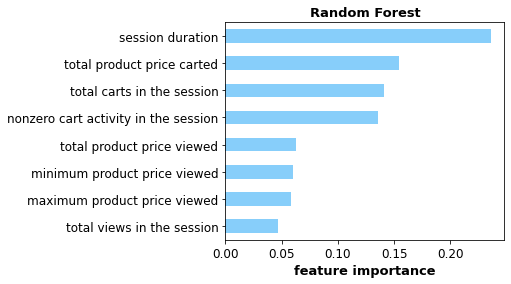

In [37]:
plot_feature_importance(df_fim_rf, 'Random Forest', 'rf')

#### Section 3.2.3 XG boost classifier <a class="anchor" id="section_3_2_3"></a> 


In [26]:
%%time
clfr = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', XGBClassifier(learning_rate=0.1, scale_pos_weight = 2.0))])

clfr.fit(X_train, y_train)

y_pred = clfr.predict(X_test)

print('\nconfusion matrix = \n', metrics.confusion_matrix(y_test, y_pred))
scores = {'accuracy': metrics.accuracy_score(y_test, y_pred),
          'precision': metrics.precision_score(y_test, y_pred),
          'recall': metrics.recall_score(y_test, y_pred),
          'f1 score': metrics.f1_score(y_test, y_pred),
          'roc auc': metrics.roc_auc_score(y_test, y_pred),
          'pr auc': metrics.average_precision_score(y_test, y_pred)}

score_metrics = pd.concat([score_metrics, pd.DataFrame(scores, index=['XG boost']).round(4)])
score_metrics

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:05:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

confusion matrix = 
 [[630808  25733]
 [  9781  49728]]
Wall time: 4min 51s


,accuracy,precision,recall,f1 score,roc auc,pr auc
Logistic,0.9339,0.5579,0.9842,0.7122,0.9568,0.5504
Random Forest,0.9464,0.7188,0.5829,0.6438,0.7811,0.4537
XG boost,0.9504,0.6590,0.8356,0.7369,0.8982,0.5643


#### Section 3.2.4  Model comparison <a class="anchor" id="section_3_2_4"></a> 
Create list of models


In [11]:
models = [
#          ('Logistic', LogisticRegression(class_weight = "balanced")),
          ('Ridge', RidgeClassifier(class_weight = "balanced")),
#          ('RidgeCV', RidgeClassifierCV()),
#          ('SVC', SVC()),
          ('Decision Tree', DecisionTreeClassifier(class_weight = "balanced")),
          ('AdaBoost', AdaBoostClassifier()),
          ('Bagging', BaggingClassifier()),
          ('Gradient Boost', GradientBoostingClassifier()),
#          ('Random Forest', RandomForestClassifier(class_weight = phone_class_weight)),
          ('XGboost', XGBClassifier(learning_rate=0.1, scale_pos_weight = 2.0)),
          ]


In [12]:
def model_fit_predict(name, clf):
    clfr = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', clf)])

    clfr.fit(X_train, y_train)

    y_pred = clfr.predict(X_test)

    print(name.rjust(16), end=':   ')
#    print('accuracy = ', metrics.accuracy_score(y_test, y_pred).round(4))
    print('f1 score = ', metrics.f1_score(y_test, y_pred).round(4))
#    print('\nconfusion matrix = \n', metrics.confusion_matrix(y_test, y_pred))

    scores = {'accuracy': metrics.accuracy_score(y_test, y_pred),
              'precision': metrics.precision_score(y_test, y_pred),
              'recall': metrics.recall_score(y_test, y_pred),
              'f1 score': metrics.f1_score(y_test, y_pred),
              'roc auc': metrics.roc_auc_score(y_test, y_pred),
              'pr auc': metrics.average_precision_score(y_test, y_pred)}

    df_score = pd.DataFrame(scores, index=[name]).round(4)

    return df_score


In [13]:
for name, clf in models:
    df_score = model_fit_predict(name, clf)
    score_metrics = pd.concat([score_metrics, df_score])


           Ridge:   f1 score =  0.7164
   Decision Tree:   f1 score =  0.5595
        AdaBoost:   f1 score =  0.6041
         Bagging:   f1 score =  0.6198
  Gradient Boost:   f1 score =  0.6595


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:45:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
         XGboost:   f1 score =  0.7369


Since the dataset is highly imbalanced. The baseline model can already achieve accuracy of 91.7%. Therefore, accuracy is not a good metric to evaluate the model performance. We want high scores both in precision and recall. If precision is low, the amount of "not purchased" sessions are classified as "purchased". This will mislead that business of over-estimated purchases than actual. On the other hand, if recall is low, some "purchased" sessions are mis-classified as "not purchased", which will under-estimate the product purchases. Consequently, for such classification problems, f1 score would be the best metric.

In [41]:
score_metrics

,accuracy,precision,recall,f1 score,roc auc,pr auc
Logistic,0.9339,0.5579,0.9842,0.7122,0.9568,0.5504
Random Forest,0.9464,0.7178,0.5850,0.6446,0.7821,0.4544
Ridge,0.9352,0.5628,0.9853,0.7164,0.9579,0.5557
Decision Tree,0.9281,0.5695,0.5511,0.5602,0.7567,0.3512
AdaBoost,0.9418,0.6951,0.5342,0.6041,0.7565,0.4100
Bagging,0.9424,0.6893,0.5590,0.6174,0.7681,0.4220
Gradient Boost,0.9470,0.7074,0.6176,0.6595,0.7972,0.4687
XGboost,0.9504,0.6590,0.8356,0.7369,0.8982,0.5643


Comparing the "f1 score" of different models, XGboost model has the highest score of 73.7%

Save score metrics to csv file

In [42]:
score_metrics.to_csv('output/07_smartphone_score_metrics.csv', index = False)

#### Section 3.2.5  Feature importance <a class="anchor" id="section_3_2_5"></a> 


[[0.96080519 0.03919481]
 [0.16436169 0.83563831]]


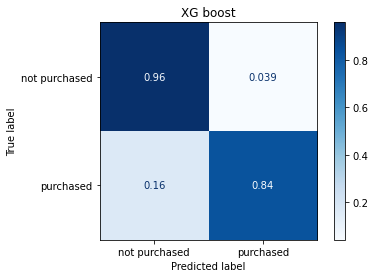

In [27]:
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(clfr, X_test, y_test,
                             display_labels = ['not purchased', 'purchased'],
                             cmap = plt.cm.Blues,
                             normalize = 'true',
#                             normalize = None,
                            )

disp.ax_.set_title('XG boost')
print(disp.confusion_matrix)


In [28]:
clfr.named_steps['classifier']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.0, subsample=1,
              tree_method='approx', validate_parameters=1, verbosity=None)

In [29]:
xgb_dict = dict(zip(['f'+str(x) for x in np.arange(len(features))], features))

feature_important = clfr.named_steps['classifier'].get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

df_fim_xgboost = pd.DataFrame(data=values,
                              index=keys,
                              columns=["feature importance"]) \
                   .reset_index()

df_fim_xgboost['index'] = df_fim_xgboost['index'].map(xgb_dict)
#df_fim_xgboost.drop(columns=['index'], inplace = True)
df_fim_xgboost.set_index('index', inplace = True)
df_fim_xgboost.sort_values(by = "feature importance", ascending=False)
df_fim_xgboost[:10]

,feature importance
index,
carts,18230.844513
session_duration,2936.869279
views,2186.893669
n_products,2503.707043
price_max,229.183903
weekday,607.788854
hour,399.321732
price_min,293.876853
n_brands,490.826547


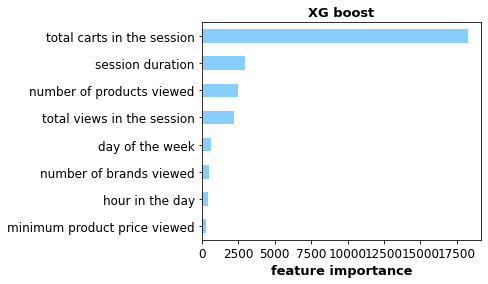

In [38]:
plot_feature_importance(df_fim_xgboost, 'XG boost', 'xgb')

In [35]:
df_fim = pd.merge(df_fim_logistic.reset_index(),
                  df_fim_rf.reset_index(drop=True),
                  on = 'index')
df_fim = pd.merge(df_fim,
                  df_fim_xgboost.reset_index(drop=True),
                  on = 'index')
df_fim.rename(columns = {'feature importance_x': 'logistic',
                         'feature importance_y': 'random forest',
                         'feature importance': 'xgboost',},
              inplace = True)
df_fim

,index,logistic,random forest,xgboost
0,views,46.338468,0.047162,2186.893669
1,view_price,13.482854,0.062982,151.282762
2,carts,8.067062,0.140968,18230.844513
3,price_min,0.832856,0.059672,293.876853
4,n_brands,-0.062618,0.007011,490.826547
5,weekday,-0.232797,0.018940,607.788854
6,hour,-0.480583,0.040150,399.321732
7,price_max,-1.281921,0.058512,229.183903
8,session_duration,-10.028295,0.236322,2936.869279
9,cart_price,-12.056084,0.154419,272.025630


In [47]:
df_fim.to_csv('output/07_smartphone_feature_importance.csv', index = False)

### Section 3.3  Summary <a class="anchor" id="section_3_c"></a> 


In [39]:
%%time
y_pred = clfr.predict(X_test)

Wall time: 560 ms


Some algorithms (logistic and ridge) tend to optimise "recall" score, and in these models there are many false positive cases. On the other hand, ensamble models tend to score better in "precision" but result in poor false negative. XGboost model achieved a more balance between "precision" and "recall" scores, and hence with a highest "f1 score" of 73.7%